# Snow Depth and Snow Cover Data Exploration 

This tutorial demonstrates how to access and compare coincident snow data across in-situ, airborne, and satellite platforms from NASA's SnowEx, ASO, and MODIS data sets, respectively. All data are available from the NASA National Snow and Ice Data Center Distributed Active Archive Center, or NSIDC DAAC. 

### Here are the steps you will learn in this snow data notebook:


* Explore the coverage, resolution, and structure of select NSIDC DAAC snow data products, as well as available resources to search and access data.
* Learn how to find and download spatiotemporally coincident data across in-situ, airborne, and satellite observations.
* Learn how to read data into Python from CSV and GeoTIFF formats.
* Learn how to extract and compare raster values at point locations.


___

## Explore snow products and resources


### NSIDC introduction

[The National Snow and Ice Data Center](https://nsidc.org) provides over 1100 data sets covering the Earth's cryosphere and more, all of which are available to the public free of charge. Beyond providing these data, NSIDC creates tools for data access, supports data users, performs scientific research, and educates the public about the cryosphere. 

#### Data Resources

* [NSIDC Data Search](https://nsidc.org/data/search/#keywords=snow)
    * Search NSIDC snow data
* [NSIDC Data Update Announcements](https://nsidc.org/the-drift/data-update/) 
    * News and tips for data users
* [NASA Earthdata Search](http://search.earthdata.nasa.gov/)
    * Search and access data across the NASA Earthdata
* [NASA Worldview](https://worldview.earthdata.nasa.gov/)
    * Interactive interface for browsing full-resolution, global, daily satellite images
    
    
#### Snow Today

[Snow Today](https://nsidc.org/snow-today), a collaboration with the University of Colorado's Institute of Alpine and Arctic Research (INSTAAR), provides near-real-time snow analysis for the western United States and regular reports on conditions during the winter season. Snow Today is funded by NASA Hydrological Sciences Program and utilizes data from the
Moderate Resolution Imaging Spectroradiometer (MODIS)instrument and snow station data from the Snow Telemetry (SNOTEL) network by the Natural Resources Conservation Service (NRCS), United States Department of Agriculture (USDA) and the California Department of Water Resources: www.wcc.nrcs.usda.gov/snow.

### Snow-related missions and data sets used in the following steps:

* [SnowEx](https://nsidc.org/data/snowex)
    * SnowEx17 Ground Penetrating Radar Version 2: https://doi.org/10.5067/G21LGCNLFSC5
* [ASO](https://nsidc.org/data/aso)
    * ASO L4 Lidar Snow Depth 3m UTM Grid Version 1: https://doi.org/10.5067/KIE9QNVG7HP0
* [MODIS](https://nsidc.org/data/modis)
    * MODIS/Terra Snow Cover Daily L3 Global 500m SIN Grid, Version 6: https://doi.org/10.5067/MODIS/MOD10A1.006


#### Other popular snow products:

* [VIIRS](https://nsidc.org/data/viirs)
    * (VIIRS/NPP CGF Snow Cover Daily L3 Global 375m SIN Grid) V1: https://doi.org/10.5067/VIIRS/VNP10A1F.001
    
AMSR-E Daily L3 SWE: AE_DySno <br />
AMSR-E 5-Day L3 SWE: AE_5DSno <br />
AMSR-E Monthly L3 SWE: AE_MoSno <br />

AMSRU Daily L3 SWE: AU_DySno <br />
AMSRU 5-Day L3 SWE: AU_5DSno <br />
AMSRU Monthly L3 SWE: AU_MoSno <br />

MEaSUREs 25 km Daily Snow Extent: NSIDC-0530 <br />
MEaSUREs 100 km Weekly Snow Extent: NSIDC-0531



___
### Import Packages

Get started by importing packages needed to run the following code blocks, including the `tutorial_helper_functions` module provided within this repository.

In [1]:
import os
import geopandas as gpd
import fiona
from shapely.geometry import Polygon, mapping
from shapely.geometry.polygon import orient
import pandas as pd 
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import numpy as np
import pyresample as prs
import requests
import json
import pprint
import getpass
from rasterio.mask import mask


# This is our functions module. We created several helper functions to discover, access, and harmonize the data below.
import tutorial_helper_functions as fn

___


## Data Discovery

Identify study area and explore data availability and coincident data over the same time and area. 


You can use NASA Earthdata Search to explore data availabilty and to access the same data below: 
https://search.earthdata.nasa.gov/projects?projectId=5366449248


### Identify area and time of interest

Since our focus is on the Grand Mesa study site of the NASA SnowEx campaign, we'll use that area to search for coincident data across other data products. From the [SnowEx17 Ground Penetrating Radar Version 2](https://doi.org/10.5067/G21LGCNLFSC5) landing page, you can find the rectangular spatial coverage under the Overview tab, or you can draw a polygon over your area of interest in the map under the Download Data tab and export the shape as a geojson file using the Export Polygon icon shown below. An example polygon geojson file is provided in the /Data folder of this repository.   

<img align="left" src="Data-download-polygon-export.png">


#### Create polygon coordinate string

Read in the geojson file as a GeoDataFrame object and simplify and reorder using the shapely package. This will be converted back to a dictionary to be applied as our polygon search parameter. 

Polygon coordinates to be used in search: -108.2352445938561,38.98556907427165,-107.85284607930835,38.978765032966244,-107.85494925720668,39.10596902171742,-108.22772795408136,39.11294532581687,-108.2352445938561,38.98556907427165


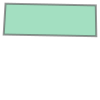

In [2]:
polygon_filepath = str(os.getcwd() + '/Data/nsidc-polygon.json') # Note: A shapefile or other vector-based spatial data format could be substituted here.

gdf = gpd.read_file(polygon_filepath) #Return a GeoDataFrame object

# Simplify polygon for complex shapes in order to pass a reasonable request length to CMR. The larger the tolerance value, the more simplified the polygon.
# Orient counter-clockwise: CMR polygon points need to be provided in counter-clockwise order. The last point should match the first point to close the polygon.
poly = orient(gdf.simplify(0.05, preserve_topology=False).loc[0],sign=1.0)

#Format dictionary to polygon coordinate pairs for CMR polygon filtering
polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])
print('Polygon coordinates to be used in search:', polygon)
poly

#### Set time range

We are interested in accessing files within each data set over the same time range, so we'll start by searching all of 2017.

In [3]:
temporal = '2017-01-01T00:00:00Z,2017-12-31T23:59:59Z' # Set temporal range

### Create data dictionary 

Create a nested dictionary with each data set short name and version, as well as shared temporal range and polygonal area of interest. **Add shortname and version info**

In [4]:
data_dict = { 'snowex': {'short_name': 'SNEX17_GPR','version': '2','polygon': polygon,'temporal':temporal},
                'aso': {'short_name': 'ASO_3M_SD','version': '1','polygon': polygon,'temporal':temporal},
             'modis': {'short_name': 'MOD10A1','version': '6','polygon': polygon,'temporal':temporal}
            }

### Determine how many files exist over this time and area of interest, as well as the average size and total volume of those files

We will use the `granule_info` function to query metadata about each data set and associated files using the [Common Metadata Repository (CMR)](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html), which is a high-performance, high-quality, continuously evolving metadata system that catalogs Earth Science data and associated service metadata records. Note that not all NSIDC data can be searched at the file level using CMR, particularly those outside of the NASA DAAC program. 

In [5]:
for k, v in data_dict.items(): fn.granule_info(data_dict[k])

There are 3 files of SNEX17_GPR version 2 over my area and time of interest.
The average size of each file is 69.73 MB and the total size of all 3 granules is 209.20 MB
There are 5 files of ASO_3M_SD version 1 over my area and time of interest.
The average size of each file is 1689.92 MB and the total size of all 5 granules is 8449.60 MB
There are 364 files of MOD10A1 version 6 over my area and time of interest.
The average size of each file is 8.23 MB and the total size of all 364 granules is 2995.34 MB


### Find coincident data

The function above tells us the size of data available for each data set over our time and area of interest, but we want to go a step further and determine what time ranges are coincident based on our bounding box. This `time_overlap` helper function returns a dataframe with file names, dataset_id, start date, and end date for all files that overlap in temporal range across all data sets of interest. 

In [6]:
search_df = fn.time_overlap(data_dict)
print(len(search_df), ' total files returned')
search_df

19  total files returned


,dataset_id,short_name,version,producer_granule_id,start_date,end_date
0,SnowEx17 Ground Penetrating Radar V002,SNEX17_GPR,002,SnowEx17_GPR_Version2_Week1.csv,2017-02-08T00:00:00.000Z,2017-02-10T23:59:59.000Z
1,SnowEx17 Ground Penetrating Radar V002,SNEX17_GPR,002,SnowEx17_GPR_Version2_Week2.csv,2017-02-14T00:00:00.000Z,2017-02-17T23:59:59.000Z
2,SnowEx17 Ground Penetrating Radar V002,SNEX17_GPR,002,SnowEx17_GPR_Version2_Week3.csv,2017-02-21T00:00:00.000Z,2017-02-25T23:59:59.000Z
3,ASO L4 Lidar Snow Depth 3m UTM Grid V001,ASO_3M_SD,001,ASO_3M_SD_USCOGM_20170208,2017-02-08T00:00:00.000Z,2017-02-08T23:59:59.000Z
4,ASO L4 Lidar Snow Depth 3m UTM Grid V001,ASO_3M_SD,001,ASO_3M_SD_USCOGM_20170216,2017-02-16T00:00:00.000Z,2017-02-16T23:59:59.000Z
6,ASO L4 Lidar Snow Depth 3m UTM Grid V001,ASO_3M_SD,001,ASO_3M_SD_USCOGM_20170221,2017-02-21T00:00:00.000Z,2017-02-21T23:59:59.000Z
7,ASO L4 Lidar Snow Depth 3m UTM Grid V001,ASO_3M_SD,001,ASO_3M_SD_USCOGM_20170225,2017-02-25T00:00:00.000Z,2017-02-25T23:59:59.000Z
46,MODIS/Terra Snow Cover Daily L3 Global 500m SI...,MOD10A1,006,MOD10A1.A2017039.h09v05.006.2017041102600.hdf,2017-02-08T16:20:00.000Z,2017-02-08T19:40:00.000Z
47,MODIS/Terra Snow Cover Daily L3 Global 500m SI...,MOD10A1,006,MOD10A1.A2017040.h09v05.006.2017042102640.hdf,2017-02-09T17:05:00.000Z,2017-02-09T18:50:00.000Z
48,MODIS/Terra Snow Cover Daily L3 Global 500m SI...,MOD10A1,006,MOD10A1.A2017041.h09v05.006.2017043095629.hdf,2017-02-10T16:10:00.000Z,2017-02-10T19:30:00.000Z


___

## Data Access

The number of files has been greatly reduced to only those needed to compare data across these data sets. Now collect the data file URLs and download each file. This CMR query will return not only the science files, but also the associated quality and metadata files if available.

In [7]:
# Create new dictionary with fields needed for CMR url search

url_df = search_df.drop(columns=['start_date', 'end_date','version','dataset_id'])
url_dict = url_df.to_dict('records')

# CMR search variables
granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'
headers= {'Accept': 'application/json'}

# Create URL list from each df row
urls = []
for i in range(len(url_dict)):
    response = requests.get(granule_search_url, params=url_dict[i], headers=headers)
    results = json.loads(response.content)
    urls.append(fn.cmr_filter_urls(results))
# flatten url list
urls = list(np.concatenate(urls))
urls

['https://n5eil01u.ecs.nsidc.org/DP1/SNOWEX/SNEX17_GPR.002/2017.02.08/SnowEx17_GPR_Version2_Week1.csv',
 'https://n5eil01u.ecs.nsidc.org/DP1/SNOWEX/SNEX17_GPR.002/2017.02.08/SnowEx17_GPR_Version2_Week1.csv.xml',
 'https://n5eil01u.ecs.nsidc.org/DP1/SNOWEX/SNEX17_GPR.002/2017.02.14/SnowEx17_GPR_Version2_Week2.csv',
 'https://n5eil01u.ecs.nsidc.org/DP1/SNOWEX/SNEX17_GPR.002/2017.02.14/SnowEx17_GPR_Version2_Week2.csv.xml',
 'https://n5eil01u.ecs.nsidc.org/DP1/SNOWEX/SNEX17_GPR.002/2017.02.21/SnowEx17_GPR_Version2_Week3.csv',
 'https://n5eil01u.ecs.nsidc.org/DP1/SNOWEX/SNEX17_GPR.002/2017.02.21/SnowEx17_GPR_Version2_Week3.csv.xml',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_3M_SD.001/2017.02.08/ASO_3M_QF_USCOGM_20170208.tif',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_3M_SD.001/2017.02.08/ASO_3M_SD_USCOGM_20170208.tif',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_3M_SD.001/2017.02.08/ASO_3M_SD_USCOGM_20170208.tif.xml',
 'https://n5eil01u.ecs.nsidc.org/DP1/ASO/ASO_3M_SD.001/2017.02.16/

This function will download all URLs in the list gathered in the previous block:

In [8]:
path = str(os.getcwd() + '/Data')
if not os.path.exists(path):
    os.mkdir(path)
os.chdir(path)
#fn.cmr_download(urls)
fn.cmr_download(urls[0:2])

### Additional access and subsetting services for MODIS

Data can be accessed directly from our HTTPS file system or through our Application Programming Interface (API). Our API offers you the ability to order data using specific temporal and spatial filters, as well as subset, reformat, and reproject select data sets. The same subsetting, reformatting, and reprojection services available on select data sets through NASA Earthdata Search can also be applied using this API. These options can be requested in a single access command without the need to script against our data directory structure. According to https://nsidc.org/support/faq/what-data-subsetting-reformatting-and-reprojection-services-are-available-for-MODIS-data, we can see that spatial subsetting and GeoTIFF reformatting are available for MOD10A1. See our programmatic access guide for more information. 

In [9]:
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request' # Set NSIDC data access base URL
data_dict['modis']['request_mode'] = 'stream' # Set the request mode to asynchronous

The area subset must be described as a bounding box, which we can create based on our polygon bounds:

In [10]:
# Get polygon bounds to be used as bounding box input
bounds = poly.bounds
data_dict['modis']['bbox'] = ','.join(map(str, list(bounds)))

Set to GeoTIFF reformatting. See the print services option for more info on services...

In [11]:
data_dict['modis']['format'] = 'GeoTIFF'

Set new temporal range based on dataframe above. Note that this will request all MOD10A1 data falling within this time range.

In [12]:
modis_start = min(search_df.loc[search_df['short_name'] == 'MOD10A1', 'start_date'])
modis_end = max(search_df.loc[search_df['short_name'] == 'MOD10A1', 'end_date'])
data_dict['modis']['temporal'] = ','.join([modis_start,modis_end])
print(data_dict['modis'])

{'short_name': 'MOD10A1', 'version': '6', 'polygon': '-108.2352445938561,38.98556907427165,-107.85284607930835,38.978765032966244,-107.85494925720668,39.10596902171742,-108.22772795408136,39.11294532581687,-108.2352445938561,38.98556907427165', 'temporal': '2017-02-08T16:20:00.000Z,2017-02-25T18:50:00.000Z', 'page_size': 2000, 'page_num': 1, 'request_mode': 'stream', 'bbox': '-108.2352445938561,38.978765032966244,-107.85284607930835,39.11294532581687', 'format': 'GeoTIFF'}


#### Create the data request API endpoint
Programmatic API requests are formatted as HTTPS URLs that contain key-value-pairs specifying the service operations that we specified above. We will first create a string of key-value-pairs from our data dictionary and we'll feed those into our API endpoint. This API endpoint can be executed via command line, a web browser, or in Python below.

In [13]:
param_string = '&'.join("{!s}={!r}".format(k,v) for (k,v) in data_dict['modis'].items()) # Convert param_dict to string
param_string = param_string.replace("'","") # Remove quotes

api_request = [f'{base_url}?{param_string}']
print(api_request) # Print API base URL + request parameters

['https://n5eil02u.ecs.nsidc.org/egi/request?short_name=MOD10A1&version=6&polygon=-108.2352445938561,38.98556907427165,-107.85284607930835,38.978765032966244,-107.85494925720668,39.10596902171742,-108.22772795408136,39.11294532581687,-108.2352445938561,38.98556907427165&temporal=2017-02-08T16:20:00.000Z,2017-02-25T18:50:00.000Z&page_size=2000&page_num=1&request_mode=stream&bbox=-108.2352445938561,38.978765032966244,-107.85284607930835,39.11294532581687&format=GeoTIFF']


In [14]:
fn.cmr_download(api_request)

1/1: request?short_name=MOD10A1&version=6&polygon=-108.2352445938561,38.98556907427165,-107.85284607930835,38.978765032966244,-107.85494925720668,39.10596902171742,-108.22772795408136,39.11294532581687,-108.2352445938561,38.98556907427165&temporal=2017-02-08T1


___
## Read in SnowEx data and buffer points around Snotel location

This SnowEx data set is provided in CSV. A [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/getting_started/overview.html) is used to easily read in data. For these next steps, just one day's worth of data will be selected from this file and the coincident ASO and MODIS data will be selected.


In [15]:
snowex_path = './SnowEx17_GPR_Version2_Week1.csv' # Define local filepath
df = pd.read_csv(snowex_path, sep='\t') 
df.head()

,collection,trace,long,lat,elev,twtt,Thickness,SWE,x,y,UTM_Zone
0,GPR_0042_020817,2581,-108.066856,39.043146,3240.2,5.89,0.692,225,753854.880092,4.325659e+06,12 S
1,GPR_0042_020817,2582,-108.066856,39.043146,3240.2,5.89,0.692,225,753854.899385,4.325660e+06,12 S
2,GPR_0042_020817,2583,-108.066856,39.043146,3240.2,5.87,0.690,224,753854.918686,4.325660e+06,12 S
3,GPR_0042_020817,2584,-108.066855,39.043146,3240.2,5.86,0.689,224,753854.937987,4.325660e+06,12 S
4,GPR_0042_020817,2585,-108.066855,39.043147,3240.2,5.84,0.686,223,753854.957280,4.325660e+06,12 S


### Convert to time values and extract a single day

The above files are descibed below according to the user guide provided by the NSIDC DAAC:

| Variable     | Description                        |
|--------------|------------------------------------|
| GPR          | Short for Ground Penetrating Radar |
| [LineNumber] | Value associated with the raw file |
| [date]       | Date in mmddyy format              |
| TRACE     | Trace number corresponding to the raw data files; each trace is the individual recording of a received signal from the GPR pulse |                 
| LONG      | Longitude                                                                                                                        |
| LAT       | Latitude                                                                                                                         |
| ELEV      | Elevation, in meters (m)                                                                                                         |
| TWTT      | Two-way travel time, in nanoseconds (ns), of the interpreted ground surface reflection                                           |
| THICKNESS | Snow depth, in meters (m)                                                                                                        |
| SWE       | Snow water equivalent (SWE), in millimeters (cm)                                                                                 |
| X         | Easting, calculated from the recorded longitude                                                                                  |
| Y         | Northing, calculated form the recorded latitude                                                                                  |
| UTM_ZONE  | UTM grid zone for the calculated easting and northing                                                                            |

The collection date needs to be extracted from the `collection` value and a new dataframe will be generated as a subset of the original based on a single day:

In [16]:
df['date'] = df.collection.str.rsplit('_').str[-1].astype(str)
df.date = pd.to_datetime(df.date, format="%m%d%y")
df = df.sort_values(['date'])
df_subset = df[df['date'] == '2017-02-08'] # subset original dataframe and only select this date
df.head()

,collection,trace,long,lat,elev,twtt,Thickness,SWE,x,y,UTM_Zone,date
0,GPR_0042_020817,2581,-108.066856,39.043146,3240.20,5.89,0.692,225,753854.880092,4.325659e+06,12 S,2017-02-08
109172,GPR_0043_020817,6360,-108.063209,39.049202,3248.49,11.49,1.350,439,754148.853700,4.326342e+06,12 S,2017-02-08
109173,GPR_0043_020817,6361,-108.063209,39.049202,3248.50,11.56,1.358,441,754148.882549,4.326342e+06,12 S,2017-02-08
109174,GPR_0043_020817,6362,-108.063208,39.049202,3248.50,11.62,1.365,444,754148.911407,4.326342e+06,12 S,2017-02-08
109175,GPR_0043_020817,6363,-108.063208,39.049202,3248.50,11.64,1.368,445,754148.947466,4.326342e+06,12 S,2017-02-08


#### Convert to Geopandas dataframe to provide point geometry

According to the documentation, the data are available in UTM and we'll need this projection in meters for the next step

In [17]:
gdf_utm= gpd.GeoDataFrame(df_subset, geometry=gpd.points_from_xy(df_subset.x, df_subset.y), crs='EPSG:32612')
gdf_utm.head()

,collection,trace,long,lat,elev,twtt,Thickness,SWE,x,y,UTM_Zone,date,geometry
0,GPR_0042_020817,2581,-108.066856,39.043146,3240.20,5.89,0.692,225,753854.880092,4.325659e+06,12 S,2017-02-08,POINT (753854.880 4325659.484)
109172,GPR_0043_020817,6360,-108.063209,39.049202,3248.49,11.49,1.350,439,754148.853700,4.326342e+06,12 S,2017-02-08,POINT (754148.854 4326341.915)
109173,GPR_0043_020817,6361,-108.063209,39.049202,3248.50,11.56,1.358,441,754148.882549,4.326342e+06,12 S,2017-02-08,POINT (754148.883 4326341.916)
109174,GPR_0043_020817,6362,-108.063208,39.049202,3248.50,11.62,1.365,444,754148.911407,4.326342e+06,12 S,2017-02-08,POINT (754148.911 4326341.917)
109175,GPR_0043_020817,6363,-108.063208,39.049202,3248.50,11.64,1.368,445,754148.947466,4.326342e+06,12 S,2017-02-08,POINT (754148.947 4326341.918)


### Buffer data around SNOTEL site

Further subset to get within 500 m radius of SNOTEL Mesa Lakes site at 39.05 -108.067 according to https://wcc.sc.egov.usda.gov/nwcc/site?sitenum=622&state=co

First we'll create a new GeoDataFrame with our SNOTEL site location, set to our SnowEx UTM coordinate reference system and create a 500 meter buffer around this point, then we'll subset SnowEx points to buffer and convert to WGS84 CRS:

In [18]:
# Create another geodataframe (gdfsel) with the center point for the selection
df_snotel = pd.DataFrame(
    {'SNOTEL Site': ['Mesa Lakes'],
     'Latitude': [39.05],
     'Longitude': [-108.067]})
gdf_snotel = gpd.GeoDataFrame(df_snotel, geometry=gpd.points_from_xy(df_snotel.Longitude, df_snotel.Latitude), crs='EPSG:4326')

gdf_snotel.to_crs('EPSG:32612', inplace=True) # set CRS to UTM 12 N

#create 500 m buffer
buffer = gdf_snotel.buffer(500)

# Use the within method of geopandas to find the points within. E.g. gdf_within =
# gdfdata.loc[gdfdata.geometry.within(gdfselbuff.unary_union)]

gdf_buffer = gdf_utm.loc[gdf_utm.geometry.within(buffer.unary_union)]
gdf_buffer = gdf_buffer.to_crs('EPSG:4326')

___
## Read in Airborne Snow Observatory data and clip to SNOTEL buffer

ASO data are provided as GeoTIFF so we'll use the Rasterio package. The read() method returns a Numpy array. Note that we also have the quality data and encourage you to use it.

In [19]:
aso_path = './ASO_3M_SD_USCOGM_20170208.tif' # Define local filepath

aso = rasterio.open(aso_path)

### Clip data to SNOTEL buffer

This is a very large file and we also want to clip, or subset our data to the same SNOTEL buffer:

In [20]:
buffer = buffer.to_crs(crs=aso.crs) # convert buffer to CRS of ASO rasterio object
out_img, out_transform = mask(aso, buffer, crop=True)
out_meta = aso.meta.copy()
epsg_code = int(aso.crs.data['init'][5:])
out_meta.update({"driver": "GTiff", "height": out_img.shape[1], "width": out_img.shape[2], "transform": out_transform, "crs": '+proj=utm +zone=13 +datum=WGS84 +units=m +no_defs'})
out_tif = 'clipped_ASO_3M_SD_USCOGM_20170208.tif'

with rasterio.open(out_tif, 'w', **out_meta) as dest:
    dest.write(out_img)
    
clipped_aso = rasterio.open(out_tif)
aso_array = clipped_aso.read(1, masked=True)

___ 
## Read in MODIS Snow Cover data 

We'll use our subsetting and reformatting service for MOD10A1...

For GIS, we can also use Worldview: https://go.nasa.gov/2WdsIR3


#### Placeholder for API subsetting/reformatting access

In [21]:
modis_path = './MOD10A1_A2017039_h09v05_006_2017041102600_MOD_Grid_Snow_500m_NDSI_Snow_Cover_99f6ee91_subsetted.tif' # Define local filepath
modis = rasterio.open(modis_path)
modis_array = modis.read(1, masked=True)

___
## Add ASO and MODIS data to GeoPandas dataframe

First, set geometry for the SnowEx data

In [22]:
snowex_geometry = prs.geometry.SwathDefinition(lons=gdf_buffer['long'], lats=gdf_buffer['lat'])
print('snowex geometry: ', snowex_geometry)

snowex geometry:  Shape: (26516,)
Lons: [-108.063209   -108.06320867 -108.06320833 ... -108.06127167 -108.061267
 -108.06214585]
Lats: [39.04920167 39.04920167 39.04920167 ... 39.04973833 39.04973658
 39.05015724]


Then create are definitions for ASO and MODIS data since they are on regular grids:

Projection and extent metadata:

In [23]:
pprint.pprint(clipped_aso.profile)
print('')
print(clipped_aso.bounds)


pprint.pprint(modis.profile)
print('')
print(modis.bounds)

{'count': 1,
 'crs': CRS.from_epsg(32613),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 334,
 'interleave': 'band',
 'nodata': -9999.0,
 'tiled': False,
 'transform': Affine(3.0, 0.0, 234081.0,
       0.0, -3.0, 4327305.0),
 'width': 335}

BoundingBox(left=234081.0, bottom=4326303.0, right=235086.0, top=4327305.0)
{'compress': 'deflate',
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["Sinusoidal Modis Spheroid",GEOGCS["Unknown datum based upon the Authalic Sphere",DATUM["Not_specified_based_on_Authalic_Sphere",SPHEROID["Sphere",6371007.181,0,AUTHORITY["EPSG","7035"]],AUTHORITY["EPSG","6035"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4035"]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 34,
 'interleave': 'band',
 'nodata': None,
 'tiled': False,
 'transform': Affine(463.3127165279165, 0

In [24]:
# Create area definition for ASO
area_id = 'UTM_13N' # area_id: ID of area
description = 'WGS 84 / UTM zone 13N' # description: Description
proj_id = 'UTM_13N' # proj_id: ID of projection (being deprecated)
projection = 'EPSG:32613' # projection: Proj4 parameters as a dict or string
width = clipped_aso.width # width: Number of grid columns
height = clipped_aso.height # height: Number of grid rows
area_extent = (234081.0, 4326303.0, 235086.0, 4327305.0)
aso_geometry = prs.geometry.AreaDefinition(area_id, description, proj_id, projection, width, height, area_extent)

In [25]:
# Create area definition for MODIS
area_id = 'Sinusoidal' # area_id: ID of area
description = 'Sinusoidal Modis Spheroid' # description: Description
proj_id = 'Sinusoidal' # proj_id: ID of projection (being deprecated)
projection = 'PROJCS["Sinusoidal Modis Spheroid",GEOGCS["Unknown datum based upon the Authalic Sphere",DATUM["Not_specified_based_on_Authalic_Sphere",SPHEROID["Sphere",6371007.181,887203.3395236016,AUTHORITY["EPSG","7035"]],AUTHORITY["EPSG","6035"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4035"]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]' # projection: Proj4 parameters as a dict or string
width = modis.width # width: Number of grid columns
height = modis.height # height: Number of grid rows
area_extent = (-9332971.361735353, 4341240.1538655795, -9331118.110869242, 4343093.404731691)
modis_geometry = prs.geometry.AreaDefinition(area_id, description, proj_id, projection, width, height, area_extent)

### Interpolate ASO and MODIS values onto SnowEx points

To easily interpolate ASO snow depth and MODIS snow cover data to SnowEx snow depth points, we can use the `pyresample` library. The `radius_of_influence` parameter determines maximum radius to look for nearest neighbor interpolation.

Masked arrays can be used as data input. In order to have undefined pixels masked out instead of assigned a fill value set fill_value=None when calling the resample_* function.


In [26]:
# add ASO values to geodataframe
gdf_buffer['aso_snow_depth'] = prs.kd_tree.resample_nearest(aso_geometry, aso_array, snowex_geometry, radius_of_influence=3)

# add MODIS values to geodataframe
gdf_buffer['modis_ndsi'] = prs.kd_tree.resample_nearest(modis_geometry, modis_array, snowex_geometry, radius_of_influence=500)

/Users/asteiker/miniconda3/envs/tutorial/lib/python3.7/site-packages/pyproj/crs.py:686: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/Users/asteiker/miniconda3/envs/tutorial/lib/python3.7/site-packages/pyproj/crs.py:686: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


In [27]:
gdf_buffer.head()

,collection,trace,long,lat,elev,twtt,Thickness,SWE,x,y,UTM_Zone,date,geometry,aso_snow_depth,modis_ndsi
109172,GPR_0043_020817,6360,-108.063209,39.049202,3248.49,11.49,1.350,439,754148.853700,4.326342e+06,12 S,2017-02-08,POINT (-108.06321 39.04920),1.302658,71
109173,GPR_0043_020817,6361,-108.063209,39.049202,3248.50,11.56,1.358,441,754148.882549,4.326342e+06,12 S,2017-02-08,POINT (-108.06321 39.04920),1.302658,71
109174,GPR_0043_020817,6362,-108.063208,39.049202,3248.50,11.62,1.365,444,754148.911407,4.326342e+06,12 S,2017-02-08,POINT (-108.06321 39.04920),1.302658,71
109175,GPR_0043_020817,6363,-108.063208,39.049202,3248.50,11.64,1.368,445,754148.947466,4.326342e+06,12 S,2017-02-08,POINT (-108.06321 39.04920),1.302658,71
109176,GPR_0043_020817,6364,-108.063207,39.049202,3248.50,11.68,1.372,446,754148.983533,4.326342e+06,12 S,2017-02-08,POINT (-108.06321 39.04920),1.302658,71


___ 
## Visualize data and export for further GIS analysis

Start with ASO data:

In [28]:
gdf_buffer_aso_crs = gdf_buffer.to_crs('EPSG:32613')

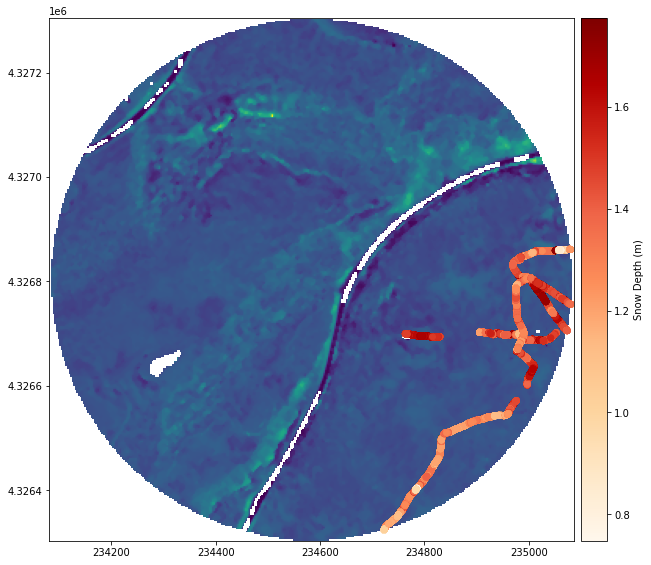

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(10, 10))
show(clipped_aso, ax=ax)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf_buffer_aso_crs.plot(column='Thickness', ax=ax, cmap='OrRd', legend=True, cax=cax, legend_kwds=
                        {'label': "Snow Depth (m)",});

In [30]:
gdf_buffer_modis_crs = gdf_buffer.to_crs('PROJCS["Sinusoidal Modis Spheroid",GEOGCS["Unknown datum based upon the Authalic Sphere",DATUM["Not_specified_based_on_Authalic_Sphere",SPHEROID["Sphere",6371007.181,887203.3395236016,AUTHORITY["EPSG","7035"]],AUTHORITY["EPSG","6035"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4035"]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]')

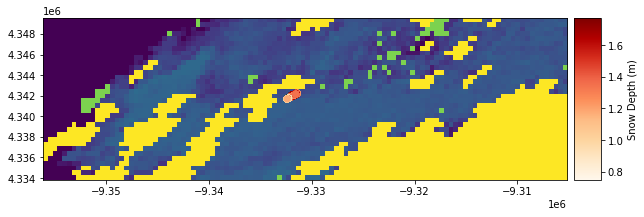

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(10, 10))
show(modis, ax=ax)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf_buffer_modis_crs.plot(column='Thickness', ax=ax, cmap='OrRd', legend=True, cax=cax, legend_kwds=
                        {'label': "Snow Depth (m)",});

### Export to Shapefile for GIS applications:

Write to shapefile for GIS applications:


In [ ]:
gdf_buffer = gdf_buffer.drop(columns=['date'])
gdf_buffer.to_file('snow-data-20170208.shp')